<h1><center>Kaggle Practice: Regression Model to Predict House Price</center></h1>
<center><font size="2">Fahim Hadi Maula</font></center>

## 1. Introduction
Regression is a method of modelling a target value based on independent predictors. This method is mostly used for forecasting and finding out cause and effect relationship between variables. Regression techniques mostly differ based on the number of independent variables and the type of relationship between the independent and dependent variables.
In this project, I want to practice how to use regression model and find out how to improve the regression model. On the first run, I would like to use all numerical data without linearity assessment. I assume the R-squared and RMSE for this model could be the baseline.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## 2. The Data: House Prices
I got the data from the Kaggle Competition. The goal from this competition is to predict sales price for each house. Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence. With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.
Dataset has been splitted into train and test. Not like train-dataset, test-dataset didn't have complete data, it's miss the SalePrice column. To complete test-dataset, we merged it with submission.csv.

In [2]:
df_train = pd.read_csv('house_price/train.csv')
df_test = pd.read_csv('house_price/test.csv')
sub = pd.read_csv('house_price/submission.csv')
df_test = pd.merge(df_test, sub, how='inner', on='Id')

### 2.1. Data Processing
The data downloaded, as mentioned above, was cleaned up and processed before using it for model fitting. There was missing value in the data that we need to handle. The data with more than 90% missing value were utterly removed. For data with less than 50%, the missing value was imputed by their median (numeric) or mode (categoric). There was a particular case for correlation in missing value, which means the data was null because data in another column was null. The data after this initial cleanup is shown in Fig 2.

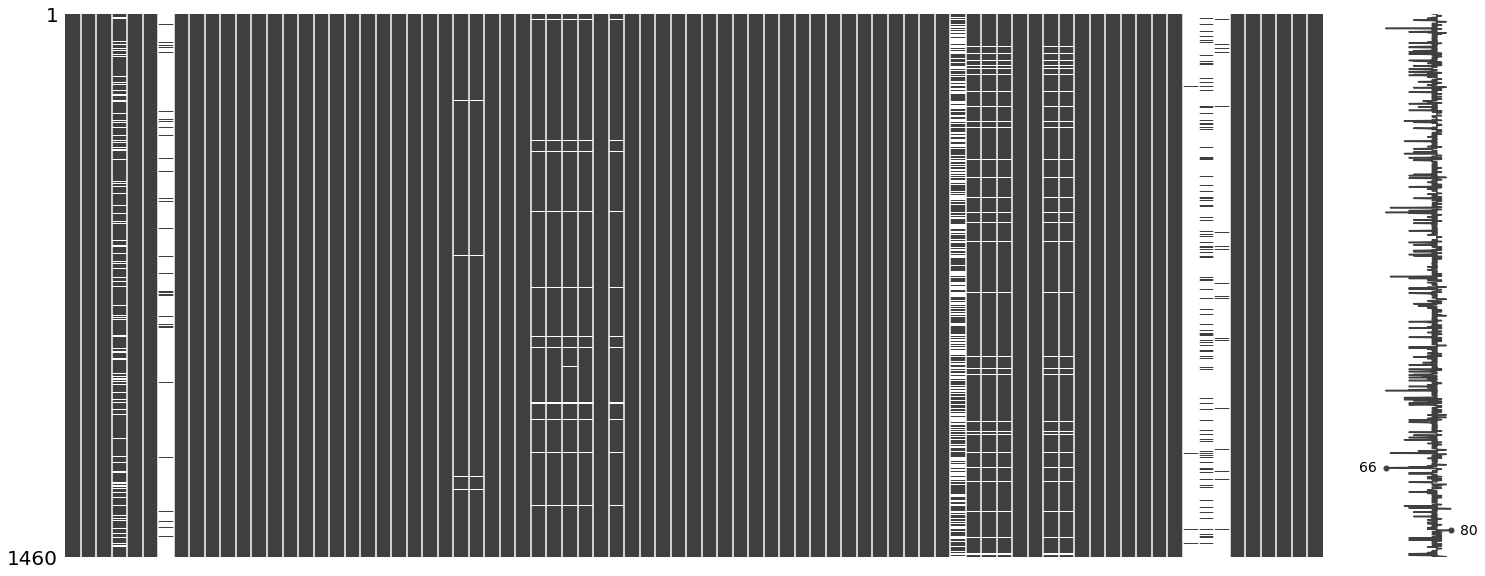

In [3]:
msno.matrix(df_train)
plt.savefig('image/miss_before.png')

<center>Fig. 1. Null values matrix for all features.</center>

In [4]:
x = df_train['LotFrontage'].median()
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(x)
df_test['LotFrontage'] = df_test['LotFrontage'].fillna(x)

df_test.loc[2152, 'Exterior1st'] = df_test['Exterior1st'].mode()[0]
df_test.loc[2152, 'Exterior2nd'] = df_test['Exterior2nd'].mode()[0]

df_train['MasVnrType'] = df_train['MasVnrType'].fillna('None')
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)

df_test['MasVnrType'] = df_test['MasVnrType'].fillna('None')
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)

x = df_train['BsmtQual'].mode()[0]
df_train['BsmtQual'].fillna(x, inplace=True)
df_test['BsmtQual'].fillna(x, inplace=True)

y = df_train['BsmtExposure'].mode()[0]
df_train['BsmtExposure'].fillna(y, inplace=True)
df_test['BsmtExposure'].fillna(y, inplace=True)

z = df_train['BsmtFinType1'].mode()[0]
df_train['BsmtFinType1'].fillna(z, inplace=True)
df_test['BsmtFinType1'].fillna(z, inplace=True)

a = df_train['BsmtFinSF1'].median()
df_test['BsmtFinSF1'].fillna(a, inplace=True)

b = df_train['BsmtFinSF2'].median()
df_test['BsmtFinSF2'].fillna(b, inplace=True)

c = df_train['BsmtUnfSF'].median()
df_test['BsmtUnfSF'].fillna(c, inplace=True)

d = df_train['TotalBsmtSF'].median()
df_test['TotalBsmtSF'].fillna(d, inplace=True)

df_test['BsmtFullBath'].fillna(0, inplace=True)

df_train['FireplaceQu'].fillna('nan', inplace=True)
df_test['FireplaceQu'].fillna('nan', inplace=True)

df_train['GarageType'].fillna('nan', inplace=True)
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].astype('float64')
df_train['GarageYrBlt'].fillna(np.nan, inplace=True)

df_test['GarageType'].fillna('nan', inplace=True)
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].astype('float64')
df_test['GarageYrBlt'].fillna(np.nan, inplace=True)

df_test['KitchenQual'].fillna('TA', inplace=True)

df_test['GarageCars'].fillna(0, inplace=True)
df_test['GarageArea'].fillna(0, inplace=True)

y = df_train['GarageYrBlt'].max()
z = df_train['GarageFinish'].mode()[0]
df_train['GarageYrBlt'].fillna(y, inplace=True)
df_train['GarageFinish'].fillna(z, inplace=True)

df_test['GarageYrBlt'].fillna(y, inplace=True)
df_test['GarageFinish'].fillna(z, inplace=True)

df_test.drop(df_test[df_test['Id'].isnull()].index, inplace=True)

df_train.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
df_test.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

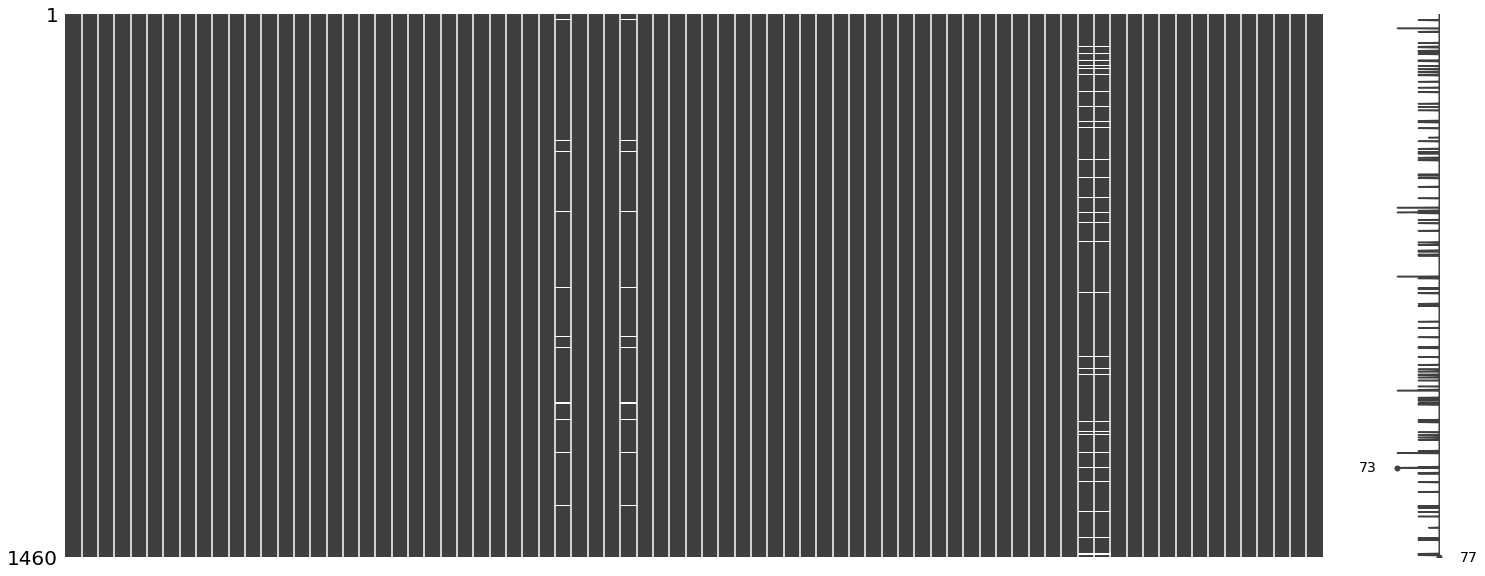

In [5]:
msno.matrix(df_train)
plt.savefig('image/miss_after.png')

<center>Fig. 2. Null values matrix after initial cleanup.</center>

After initial cleanup, next step was to check variation in categorical data. I used a simple matrix by compared number of each value and their average. The higher result means that column almost contains one value and not fairly distributed. So it can be completely removed when the result more than 70.

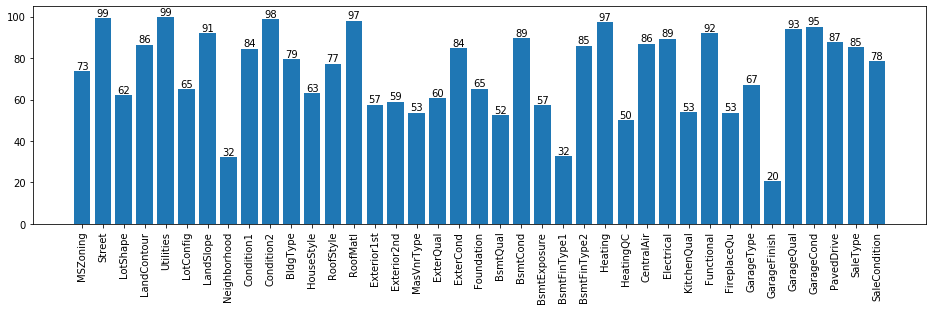

In [6]:
R_dict = {}
df_ = df_train.select_dtypes(include=['object', 'category'])
for col in df_.columns:
    df_obs = df_.loc[~df_[col].isnull(), col]
    total_observ = df_obs.shape[0]
    total_cat = len(df_obs.unique())
    avg = total_observ/total_cat
    max_r_ = abs(total_observ-avg)+abs((0-avg)*(total_cat-1))

    cout = []
    for cat in df_obs.unique():
        R_ = abs(df_obs.value_counts()[cat] - avg)
        cout.append(R_)
    R_sum = sum(cout)
    R_percent = R_sum/max_r_*100

    R_dict[col] = R_percent
plt.figure(figsize=(16,4))
bar1 = plt.bar(range(len(R_dict)), list(R_dict.values()), align='center')
plt.xticks(range(len(R_dict)), list(R_dict.keys()), rotation=90)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.savefig('image/variations.png')

<center>Fig. 3. Categorical variation matrix.</center>

In [7]:
col_drop = ['MSZoning', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2',
            'BldgType', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating',
            'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr','Functional',
            'GarageQual', 'GarageCond', 'PavedDrive','EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'PoolArea', 'MiscVal']

In [8]:
df_train.drop(col_drop, axis=1, inplace=True)
df_test.drop(col_drop, axis=1, inplace=True)

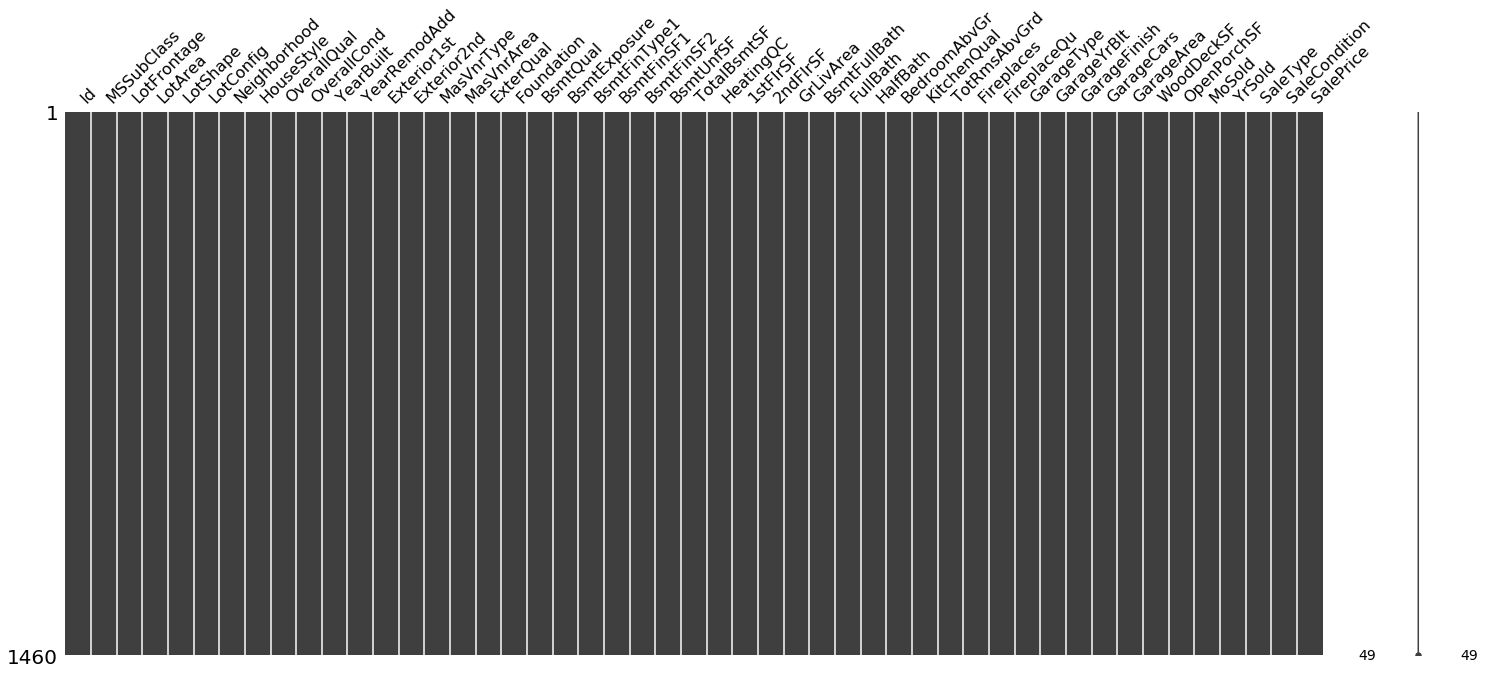

In [9]:
msno.matrix(df_train)
plt.savefig('image/miss_total_cleanup.png')

<center>Fig. 4. Missing value matrix after total cleanup.</center>

### 2.2. Feature Engineering
Feature selection and engineering in regression model based on some assumption:
- All variables are continuous numeric, not categorical
- Data is free of missing values and outliers
- There is a linear relationship between predictors and predictant
- All predictors are independent of each other
- Residuals (aka prediction errors) are normally distributed
- No heteroscedacity
- Absence of multicollinearity abd auto-correlation

#### 2.2.1. Numeric Value Without Further Engineering
Regression model assume that all features are numeric. Due to the goal of this section is to create baseline, just selected all numeric features, removed all categoric with no further feature engineering.

In [10]:
df_221 = df_train.select_dtypes(exclude=['object'])
y_221 = df_train['SalePrice'].values
X_221 = df_221.iloc[:,1:-1].values
df_221.iloc[:,1:-1].columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'MoSold', 'YrSold'],
      dtype='object')

#### 2.2.2 Standardize the numeric value
Using the dataset described and features selection in the previous section.

In [11]:
scaler = StandardScaler()
df_222 = df_train.select_dtypes(exclude=['object'])
y_222 = df_train['SalePrice'].values
X_222 = df_222.iloc[:,1:-1].values
X_222 = scaler.fit_transform(X_222)
df_222.iloc[:,1:-1].columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'MoSold', 'YrSold'],
      dtype='object')

#### 2.2.3 Numeric value, standard and Outlier Handling

In [12]:
df_223 = df_train.select_dtypes(exclude=['object'])

for col in df_223.iloc[:,2:].columns:
    q1 = df_223[col].quantile(0.25)
    q3 = df_223[col].quantile(0.75)
    iqr = q3 - q1
    upper_out = q3 + 1.5*iqr
    bottom_out = q1 - 1.5*iqr
    
    def outlier_handling(x):
        if x < bottom_out:
            return bottom_out
        elif x > upper_out:
            return upper_out
        else:
            return x
    
    df_223[col] = df_223[col].apply(lambda x: outlier_handling(x))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
y_223 = df_223['SalePrice'].values
X_223 = df_223.iloc[:,1:-1].values
X_223 = scaler.fit_transform(X_223)

#### 2.2.4. One-Hot Encoding with Correlation Above .5

In [14]:
df_train_ = df_train.copy()
df_train_.set_index('Id', inplace=True)
df_224_num = df_train_.select_dtypes(exclude=['object'])
df_224_cat = df_train_.select_dtypes(include=['object'])

df_224_num.reset_index(inplace=True)
df_224_cat.reset_index(inplace=True)

df_224_cat = pd.get_dummies(df_224_cat, prefix_sep='_')
df_224_cat.reset_index(inplace=True, drop=True)

df_224 = pd.merge(df_224_cat, df_224_num, how='left', on='Id')

In [15]:
corr_224 = df_224.iloc[:,1:].corr()
corr_224 = corr_224[((corr_224['SalePrice'] >= 0.5) | (corr_224['SalePrice'] <= -0.5)) & ((corr_224['SalePrice'] > -1) & (corr_224['SalePrice'] < 1))]
cols_224 = corr_224.index.tolist()

df_224.set_index('Id', inplace=True)
df_224 = df_224.loc[:, cols_224]

In [16]:
for col in df_224.columns:
    q1 = df_224[col].quantile(0.25)
    q3 = df_224[col].quantile(0.75)
    iqr = q3 - q1
    upper_out = q3 + 1.5*iqr
    bottom_out = q1 - 1.5*iqr
    
    def outlier_handling(x):
        if x < bottom_out:
            return bottom_out
        elif x > upper_out:
            return upper_out
        else:
            return x
    
    df_224[col] = df_224[col].apply(lambda x: outlier_handling(x))

In [17]:
y_224 = df_train_['SalePrice'].values
X_224 = df_224.values
X_224 = scaler.fit_transform(X_224)

#### 2.2.5. One-Hot Encoding with Correlation Above .3

In [18]:
df_train_ = df_train.copy()
df_train_.set_index('Id', inplace=True)
df_225_num = df_train_.select_dtypes(exclude=['object'])
df_225_cat = df_train_.select_dtypes(include=['object'])

df_225_num.reset_index(inplace=True)
df_225_cat.reset_index(inplace=True)

df_225_cat = pd.get_dummies(df_225_cat, prefix_sep='_')
df_225_cat.reset_index(inplace=True, drop=True)

df_225 = pd.merge(df_225_cat, df_225_num, how='left', on='Id')

In [19]:
corr_225 = df_225.iloc[:,1:].corr()
corr_225 = corr_225[((corr_225['SalePrice'] >= 0.3) | (corr_225['SalePrice'] <= -0.3)) & ((corr_225['SalePrice'] > -1) & (corr_225['SalePrice'] < 1))]
cols_225 = corr_225.index.tolist()

df_225.set_index('Id', inplace=True)
df_225 = df_225.loc[:, cols_225]

In [20]:
for col in df_225.columns:
    q1 = df_225[col].quantile(0.25)
    q3 = df_225[col].quantile(0.75)
    iqr = q3 - q1
    upper_out = q3 + 1.5*iqr
    bottom_out = q1 - 1.5*iqr
    
    def outlier_handling(x):
        if x < bottom_out:
            return bottom_out
        elif x > upper_out:
            return upper_out
        else:
            return x
    
    df_225[col] = df_225[col].apply(lambda x: outlier_handling(x))

In [21]:
y_225 = df_train_['SalePrice'].values
X_225 = df_225.values
X_225 = scaler.fit_transform(X_225)

#### 2.2.6. One-Hot Encoding with Correlation Above .1

In [22]:
df_train_ = df_train.copy()
df_train_.set_index('Id', inplace=True)
df_226_num = df_train_.select_dtypes(exclude=['object'])
df_226_cat = df_train_.select_dtypes(include=['object'])

df_226_num.reset_index(inplace=True)
df_226_cat.reset_index(inplace=True)

df_226_cat = pd.get_dummies(df_226_cat, prefix_sep='_')
df_226_cat.reset_index(inplace=True, drop=True)

df_226 = pd.merge(df_226_cat, df_226_num, how='left', on='Id')

In [23]:
corr_226 = df_226.iloc[:,1:].corr()
corr_226 = corr_226[((corr_226['SalePrice'] >= 0.1) | (corr_226['SalePrice'] <= -0.1)) & ((corr_226['SalePrice'] > -1) & (corr_226['SalePrice'] < 1))]
cols_226 = corr_226.index.tolist()

df_226.set_index('Id', inplace=True)
df_226 = df_226.loc[:, cols_226]

In [24]:
for col in df_226.columns:
    q1 = df_226[col].quantile(0.25)
    q3 = df_226[col].quantile(0.75)
    iqr = q3 - q1
    upper_out = q3 + 1.5*iqr
    bottom_out = q1 - 1.5*iqr
    
    def outlier_handling(x):
        if x < bottom_out:
            return bottom_out
        elif x > upper_out:
            return upper_out
        else:
            return x
    
    df_226[col] = df_226[col].apply(lambda x: outlier_handling(x))

In [25]:
y_226 = df_train_['SalePrice'].values
X_226 = df_226.values
X_226 = scaler.fit_transform(X_226)

### 3. Training of Regression Model
Using the dataset with features selection in the previous section, various models were trained and compared.

#### 3.1. Model Training: Feature 2.2.1

In [26]:
reg_221 = LinearRegression()
reg_221.fit(X_221, y_221)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
reg_221.score(X_221, y_221)

0.811538794611881

In [28]:
y_train_221 = reg_221.predict(X_221)
np.sqrt(mean_squared_error(y_true=y_221, y_pred=y_train_221))

34475.860814821695

In [29]:
reg_221.coef_

array([-2.09665894e+02, -7.70098616e+01,  4.34117749e-01,  1.80732818e+04,
        5.12955066e+03,  2.43820188e+02,  1.19090279e+02,  3.20337074e+01,
        9.90873289e+00,  1.43098504e+00, -8.23605447e-01,  1.05161125e+01,
        2.12458809e+01,  2.37681600e+01,  2.68109637e+01,  8.57148052e+03,
        1.97965513e+03, -1.55984055e+03, -9.63530530e+03,  4.02416519e+03,
        5.63014201e+03,  1.73565734e+02,  1.27677216e+04, -4.81269106e+00,
        2.06707347e+01, -1.84572283e+00, -4.71000321e+01, -7.66864445e+02])

In [30]:
reg_221.intercept_

411780.8240664884

In [31]:
df_test_221 = df_test.select_dtypes(exclude=['object'])

In [32]:
X_test_221 = df_test_221.iloc[:,1:-1].values
y_true_221 = df_test_221['SalePrice'].values

y_pred_221 = reg_221.predict(X_test_221)

In [33]:
# R-square
RSQ_221 = reg_221.score(X_test_221, y_true_221)

In [34]:
# RSME
RMSE_221 = np.sqrt(mean_squared_error(y_true=y_true_221, y_pred=y_pred_221))

#### 3.2. Model Training: Feature 2.2.2

In [35]:
reg_222 = LinearRegression()
reg_222.fit(X_222, y_222)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
reg_222.score(X_222, y_222)

0.8115387946118812

In [37]:
y_train_222 = reg_222.predict(X_222)
np.sqrt(mean_squared_error(y_true=y_222, y_pred=y_train_222))

34475.860814821695

In [38]:
reg_222.coef_

array([-8865.9491972 , -1695.76732218,  4331.56009023, 24986.72482286,
        5706.20539294,  7361.55537745,  2457.82509304,  5787.51288932,
        4581.05657485,   253.13770241,  -302.52250405,  4551.05588833,
        8210.58374253, 10371.92384808, 14083.80977611,  4446.30866026,
        1090.24972779,  -784.15232517, -7857.57817491,  6538.61069285,
        3628.32009093,  4347.1917959 ,  9538.24180844, -1028.62419943,
        2589.95753742,  -122.2483754 ,  -127.29726391, -1018.12007687])

In [39]:
df_test_222 = df_test.select_dtypes(exclude=['object'])

X_test_222 = df_test_222.iloc[:,1:-1].values
X_test_222 = scaler.fit_transform(X_test_222)
y_true_222 = df_test_222['SalePrice'].values

y_pred_222 = reg_222.predict(X_test_222)

In [40]:
# R-square
RSQ_222 = reg_222.score(X_test_222, y_true_222)

In [41]:
# RSME
RMSE_222 = np.sqrt(mean_squared_error(y_true=y_true_222, y_pred=y_pred_222))

In [42]:
reg_222.intercept_

180921.19589041095

In [43]:
df_ = pd.DataFrame(zip(df_test_222.iloc[:,1:-1].columns, reg_222.coef_), columns=['Feature', 'Coef'])

In [44]:
df_.sort_values('Coef')

,Feature,Coef
0,MSSubClass,-8865.949197
18,BedroomAbvGr,-7857.578175
1,LotFrontage,-1695.767322
23,GarageArea,-1028.624199
27,YrSold,-1018.120077
17,HalfBath,-784.152325
10,BsmtUnfSF,-302.522504
26,MoSold,-127.297264
25,OpenPorchSF,-122.248375
9,BsmtFinSF2,253.137702


#### 3.3. Model Training: Feature 2.2.3

In [45]:
reg_223 = LinearRegression()
reg_223.fit(X_223, y_223)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
reg_223.score(X_223, y_223)

0.8795652686756916

In [47]:
y_train_223 = reg_223.predict(X_223)
np.sqrt(mean_squared_error(y_true=y_223, y_pred=y_train_223))

23314.9280406982

In [48]:
df_test_223 = df_test.select_dtypes(exclude=['object'])

for col in df_test_223.iloc[:,2:-1].columns:
    q1 = df_test_223[col].quantile(0.25)
    q3 = df_test_223[col].quantile(0.75)
    iqr = q3 - q1
    upper_out = q3 + 1.5*iqr
    bottom_out = q1 - 1.5*iqr
    
    def outlier_handling(x):
        if x < bottom_out:
            return bottom_out
        elif x > upper_out:
            return upper_out
        else:
            return x
    
    df_test_223[col] = df_test_223[col].apply(lambda x: outlier_handling(x))

X_test_223 = df_test_223.iloc[:,1:-1].values
X_test_223 = scaler.fit_transform(X_test_223)
y_true_223 = df_test_223['SalePrice'].values

y_pred_223 = reg_223.predict(X_test_223)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
# R-square
RSQ_223 = reg_223.score(X_test_223, y_true_223)

In [50]:
# RSME
RMSE_223 = np.sqrt(mean_squared_error(y_true=y_true_223, y_pred=y_pred_223))

In [51]:
reg_223.coef_

array([-4.07203337e+03,  8.23429604e+02,  5.05064923e+03,  1.90011681e+04,
        6.25755958e+03,  1.00238015e+04,  4.18254655e+03,  1.67846929e+03,
        2.68923125e+03, -3.60387276e-11, -3.07680570e+03,  1.03189793e+04,
       -5.11900643e+03, -2.51051326e+03,  2.97461941e+04,  2.08124211e+03,
       -2.06774032e+02, -1.61478651e+03, -4.78380363e+03, -2.06226297e+02,
        3.81012858e+03,  2.61730267e+03,  5.60258311e+03,  1.47873951e+03,
        1.95300023e+03,  1.42020535e+03,  7.33315555e+02, -7.30005756e+02])

In [52]:
reg_223.intercept_

177331.52636986302

In [53]:
df_ = pd.DataFrame(zip(df_test_223.iloc[:,1:-1].columns, reg_223.coef_), columns=['Feature', 'Coef'])
df_.sort_values('Coef')

,Feature,Coef
12,1stFlrSF,-5.119006e+03
18,BedroomAbvGr,-4.783804e+03
0,MSSubClass,-4.072033e+03
10,BsmtUnfSF,-3.076806e+03
13,2ndFlrSF,-2.510513e+03
17,HalfBath,-1.614787e+03
27,YrSold,-7.300058e+02
16,FullBath,-2.067740e+02
19,TotRmsAbvGrd,-2.062263e+02
9,BsmtFinSF2,-3.603873e-11


#### 3.4. Model Training: Feature 2.2.4

In [54]:
reg_224 = LinearRegression()
reg_224.fit(X_224, y_224)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
reg_224.score(X_224, y_224)

0.7867715370048156

In [57]:
y_train_224 = reg_224.predict(X_224)
np.sqrt(mean_squared_error(y_true=y_224, y_pred=y_train_224))

36671.33535187401

In [58]:
df_test_ = df_test.copy()
df_test_.set_index('Id', inplace=True)
df_test_224_num = df_test_.select_dtypes(exclude=['object'])
df_test_224_cat = df_test_.select_dtypes(include=['object'])

df_test_224_num.reset_index(inplace=True)
df_test_224_cat.reset_index(inplace=True)

df_test_224_cat = pd.get_dummies(df_test_224_cat, prefix_sep='_')
df_test_224_cat.reset_index(inplace=True, drop=True)

df_test_224 = pd.merge(df_test_224_cat, df_test_224_num, how='left', on='Id')

In [59]:
df_test_224['Id'] = df_test_224['Id'].astype('int64')
df_test_224.set_index('Id', inplace=True)
df_test_224 = df_test_224.loc[:, cols_224]

In [60]:
for col in df_test_224.columns:
    q1 = df_test_224[col].quantile(0.25)
    q3 = df_test_224[col].quantile(0.75)
    iqr = q3 - q1
    upper_out = q3 + 1.5*iqr
    bottom_out = q1 - 1.5*iqr
    
    def outlier_handling(x):
        if x < bottom_out:
            return bottom_out
        elif x > upper_out:
            return upper_out
        else:
            return x
    
    df_test_224[col] = df_test_224[col].apply(lambda x: outlier_handling(x))

In [61]:
df_224.head()

,ExterQual_TA,BsmtQual_Ex,KitchenQual_Ex,KitchenQual_TA,GarageFinish_Unf,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
Id,,,,,,,,,,,,,,,
1,0,0.0,0.0,0,0,7.0,2003.0,2003,856.0,856.0,1710.0,2,8.0,2.0,548.0
2,1,0.0,0.0,1,0,6.0,1976.0,1976,1262.0,1262.0,1262.0,2,6.0,2.0,460.0
3,0,0.0,0.0,0,0,7.0,2001.0,2002,920.0,920.0,1786.0,2,6.0,2.0,608.0
4,1,0.0,0.0,0,1,7.0,1915.0,1970,756.0,961.0,1717.0,1,7.0,3.0,642.0
5,0,0.0,0.0,0,0,8.0,2000.0,2000,1145.0,1145.0,2198.0,2,9.0,3.0,836.0


In [62]:
df_test_224.head()

,ExterQual_TA,BsmtQual_Ex,KitchenQual_Ex,KitchenQual_TA,GarageFinish_Unf,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
Id,,,,,,,,,,,,,,,
1461,1,0.0,0.0,1,1,5.0,1961.0,1961.0,882.0,896.0,896.0,1.0,5.0,1.0,730.0
1462,1,0.0,0.0,0,1,6.0,1958.0,1958.0,1329.0,1329.0,1329.0,1.0,6.0,1.0,312.0
1463,1,0.0,0.0,1,0,5.0,1997.0,1998.0,928.0,928.0,1629.0,2.0,6.0,2.0,482.0
1464,1,0.0,0.0,0,0,6.0,1998.0,1998.0,926.0,926.0,1604.0,2.0,7.0,2.0,470.0
1465,0,0.0,0.0,0,0,8.0,1992.0,1992.0,1280.0,1280.0,1280.0,2.0,5.0,2.0,506.0


In [63]:
X_test_224 = df_test_224.values
X_test_224 = scaler.fit_transform(X_test_224)
y_true_224 = df_test_['SalePrice'].values

y_pred_224 = reg_224.predict(X_test_224)

In [64]:
# R-square
RSQ_224 = reg_224.score(X_test_224, y_true_224)

In [65]:
# RSME
RMSE_224 = np.sqrt(mean_squared_error(y_true=y_true_224, y_pred=y_pred_224))

#### 3.5. Model Training: Feature 2.2.5

In [66]:
reg_225 = LinearRegression()
reg_225.fit(X_225, y_225)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
reg_225.score(X_225, y_225)

0.8441400976150593

In [68]:
y_train_225 = reg_225.predict(X_225)
np.sqrt(mean_squared_error(y_true=y_225, y_pred=y_train_225))

31352.43935126899

In [69]:
df_test_ = df_test.copy()
df_test_.set_index('Id', inplace=True)
df_test_225_num = df_test_.select_dtypes(exclude=['object'])
df_test_225_cat = df_test_.select_dtypes(include=['object'])

df_test_225_num.reset_index(inplace=True)
df_test_225_cat.reset_index(inplace=True)

df_test_225_cat = pd.get_dummies(df_test_225_cat, prefix_sep='_')
df_test_225_cat.reset_index(inplace=True, drop=True)

df_test_225 = pd.merge(df_test_225_cat, df_test_225_num, how='left', on='Id')

In [70]:
df_test_225['Id'] = df_test_225['Id'].astype('int64')
df_test_225.set_index('Id', inplace=True)
df_test_225 = df_test_225.loc[:, cols_225]

In [71]:
for col in df_test_225.columns:
    q1 = df_test_225[col].quantile(0.25)
    q3 = df_test_225[col].quantile(0.75)
    iqr = q3 - q1
    upper_out = q3 + 1.5*iqr
    bottom_out = q1 - 1.5*iqr
    
    def outlier_handling(x):
        if x < bottom_out:
            return bottom_out
        elif x > upper_out:
            return upper_out
        else:
            return x
    
    df_test_225[col] = df_test_225[col].apply(lambda x: outlier_handling(x))

In [72]:
X_test_225 = df_test_225.values
X_test_225 = scaler.fit_transform(X_test_225)
y_true_225 = df_test_['SalePrice'].values

y_pred_225 = reg_225.predict(X_test_225)

In [73]:
# R-square
RSQ_225 = reg_225.score(X_test_225, y_true_225)

In [74]:
# RSME
RMSE_225 = np.sqrt(mean_squared_error(y_true=y_true_225, y_pred=y_pred_225))

#### 3.6. Model Training: Feature 2.2.6

In [75]:
reg_226 = LinearRegression()
reg_226.fit(X_226, y_226)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
reg_226.score(X_226, y_226)

0.8533466852199434

In [77]:
y_train_226 = reg_226.predict(X_226)
np.sqrt(mean_squared_error(y_true=y_226, y_pred=y_train_226))

30412.356890883995

In [63]:
df_test_ = df_test.copy()
df_test_.set_index('Id', inplace=True)
df_test_226_num = df_test_.select_dtypes(exclude=['object'])
df_test_226_cat = df_test_.select_dtypes(include=['object'])

df_test_226_num.reset_index(inplace=True)
df_test_226_cat.reset_index(inplace=True)

df_test_226_cat = pd.get_dummies(df_test_226_cat, prefix_sep='_')
df_test_226_cat.reset_index(inplace=True, drop=True)

df_test_226 = pd.merge(df_test_226_cat, df_test_226_num, how='left', on='Id')

In [64]:
df_test_226['Id'] = df_test_226['Id'].astype('int64')
df_test_226.set_index('Id', inplace=True)
df_test_226 = df_test_226.loc[:, cols_226]

In [65]:
for col in df_test_226.columns:
    q1 = df_test_226[col].quantile(0.25)
    q3 = df_test_226[col].quantile(0.75)
    iqr = q3 - q1
    upper_out = q3 + 1.5*iqr
    bottom_out = q1 - 1.5*iqr
    
    def outlier_handling(x):
        if x < bottom_out:
            return bottom_out
        elif x > upper_out:
            return upper_out
        else:
            return x
    
    df_test_226[col] = df_test_226[col].apply(lambda x: outlier_handling(x))

In [66]:
X_test_226 = df_test_226.values
X_test_226 = scaler.fit_transform(X_test_226)
y_true_226 = df_test_['SalePrice'].values

y_pred_226 = reg_226.predict(X_test_226)

In [67]:
# R-square
RSQ_226 = reg_226.score(X_test_226, y_true_226)

In [68]:
# RSME
RMSE_226 = np.sqrt(mean_squared_error(y_true=y_true_226, y_pred=y_pred_226))

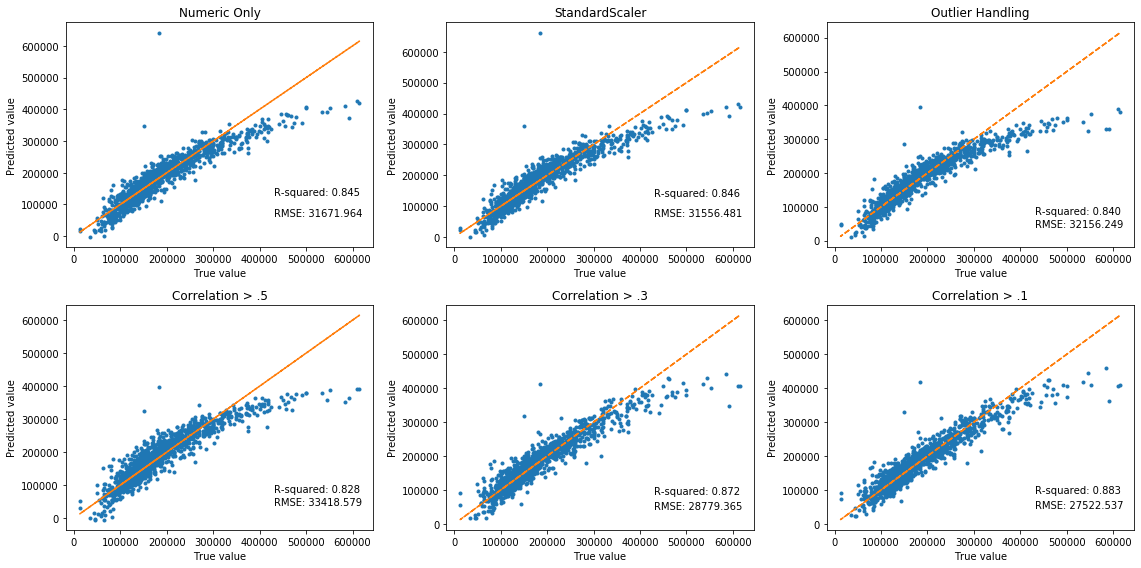

In [90]:
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.reshape(6)

y_true = [y_true_221, y_true_222, y_true_223, y_true_224, y_true_225, y_true_226]
y_pred = [y_pred_221, y_pred_222, y_pred_223, y_pred_224, y_pred_225, y_pred_226]
RSQ = [RSQ_221, RSQ_222, RSQ_223, RSQ_224, RSQ_225, RSQ_226]
RMSE = [RMSE_221, RMSE_222, RMSE_223, RMSE_224, RMSE_225, RMSE_226]
title = ['Numeric Only', 'StandardScaler', 'Outlier Handling', 'Correlation > .5', 'Correlation > .3', 'Correlation > .1']

for i in range(6):
    ax[i].plot(y_true[i], y_pred[i], '.')
    ax[i].set_title(title[i])
    ax[i].set_xlabel('True value')
    ax[i].set_ylabel('Predicted value')
    ax[i].annotate('R-squared: {0:.3f}'.format(RSQ[i]), xy=(0.7*max(y_true[i]), 0.2*max(y_pred[i])))
    ax[i].annotate('RMSE: {0:.3f}'.format(RMSE[i]), xy=(0.7*max(y_true[i]), 0.1*max(y_pred[i])))
    ax[i].plot(y_true[i], y_true[i], '--')

fig.tight_layout()

plt.savefig('image/result.png')

In [71]:
df_sub = df_test.copy()
df_sub['SalePrice'] = y_pred_226
df_sub['Id'] = df_sub['Id'].astype('int64')
df_sub.to_csv('submission.csv', columns=['Id', 'SalePrice'], index=False)